# Temporal Graph Analysis

This notebook analyzes the temporal evolution of the transaction graph, including:
- Node appearance patterns (new vs existing nodes per timestep)
- Transaction patterns (new-to-new, new-to-old, old-to-old)
- Node activity patterns (single vs multiple transactions)
- Temporal concentration of node activity

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from tqdm import tqdm

# set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
import sys
from pathlib import Path

# Add parent directory to path to import utility functions
ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

from code_lib.utils import load_parts

DATA_DIR = "../elliptic_dataset"

# Load node data
nodes_df = pd.read_csv(os.path.join(DATA_DIR, "wallets_features_classes_combined.csv"))
print(f"Nodes: {nodes_df.shape}")

# Load edge data - use the correct file that includes Time step column
# AddrAddr_edgelist.csv doesn't have Time step, but AddrTxAddr_edgelist does
edges_df = load_parts(DATA_DIR, "AddrTxAddr_edgelist_part_")
print(f"Edges: {edges_df.shape}")

print("\nNode columns:", nodes_df.columns.tolist()[:5], "...")
print("Edge columns:", edges_df.columns.tolist())

Nodes: (1268260, 58)
Edges: (2868964, 187)

Node columns: ['address', 'Time step', 'class', 'num_txs_as_sender', 'num_txs_as receiver'] ...
Edge columns: ['input_address', 'txId', 'Time step', 'Local_feature_1', 'Local_feature_2', 'Local_feature_3', 'Local_feature_4', 'Local_feature_5', 'Local_feature_6', 'Local_feature_7', 'Local_feature_8', 'Local_feature_9', 'Local_feature_10', 'Local_feature_11', 'Local_feature_12', 'Local_feature_13', 'Local_feature_14', 'Local_feature_15', 'Local_feature_16', 'Local_feature_17', 'Local_feature_18', 'Local_feature_19', 'Local_feature_20', 'Local_feature_21', 'Local_feature_22', 'Local_feature_23', 'Local_feature_24', 'Local_feature_25', 'Local_feature_26', 'Local_feature_27', 'Local_feature_28', 'Local_feature_29', 'Local_feature_30', 'Local_feature_31', 'Local_feature_32', 'Local_feature_33', 'Local_feature_34', 'Local_feature_35', 'Local_feature_36', 'Local_feature_37', 'Local_feature_38', 'Local_feature_39', 'Local_feature_40', 'Local_feature_4

In [3]:
# Display basic info
print("Time step range:", nodes_df['Time step'].min(), "to", nodes_df['Time step'].max())
print("Total unique addresses:", nodes_df['address'].nunique())
print("\nFirst few rows of nodes:")
nodes_df.head()

Time step range: 1 to 49
Total unique addresses: 822942

First few rows of nodes:


Time step range: 1 to 49
Total unique addresses: 822942

First few rows of nodes:


,address,Time step,class,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,111112TykSw72ztDN2WJger4cynzWYC5w,25,2,0.0,1.0,439586.0,439586.0,0.0,1.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,24.0,1.0,1.0,1.0,1.0
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,25,3,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,29,3,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
3,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,3,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
4,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,3,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0


In [4]:
print("\nFirst few rows of edges:")
edges_df.head()


First few rows of edges:



First few rows of edges:


,input_address,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,output_address,class
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,230325127,1,-0.128834,0.048298,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,7.000303,7.000303,7.000303,0.173495,6.825808,3.499652,3.499652,6.999303,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH,3
1,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,230325127,1,-0.128834,0.048298,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,7.000303,7.000303,7.000303,0.173495,6.825808,3.499652,3.499652,6.999303,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,3
2,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,230325139,1,-0.138128,-0.184668,-1.201369,0.028105,-0.063725,-0.113002,0.547008,...,1.841967,1.194726,5.525902,5.525802,5.525802,5.525802,5.525802,5.525802,1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G,3
3,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,86875675,1,-0.098483,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,...,3.937091,3.852260,11.811274,1.266853,10.544321,5.905587,5.905587,11.811174,19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c,3
4,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,86875675,1,-0.098483,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,...,3.937091,3.852260,11.811274,1.266853,10.544321,5.905587,5.905587,11.811174,1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA,3


In [5]:
# Check what columns are actually available
print("\nActual edge columns:")
print(edges_df.columns.tolist())
print(f"\nEdge dataframe shape: {edges_df.shape}")
print("\nFirst few rows:")
print(edges_df.head())


Actual edge columns:
['input_address', 'txId', 'Time step', 'Local_feature_1', 'Local_feature_2', 'Local_feature_3', 'Local_feature_4', 'Local_feature_5', 'Local_feature_6', 'Local_feature_7', 'Local_feature_8', 'Local_feature_9', 'Local_feature_10', 'Local_feature_11', 'Local_feature_12', 'Local_feature_13', 'Local_feature_14', 'Local_feature_15', 'Local_feature_16', 'Local_feature_17', 'Local_feature_18', 'Local_feature_19', 'Local_feature_20', 'Local_feature_21', 'Local_feature_22', 'Local_feature_23', 'Local_feature_24', 'Local_feature_25', 'Local_feature_26', 'Local_feature_27', 'Local_feature_28', 'Local_feature_29', 'Local_feature_30', 'Local_feature_31', 'Local_feature_32', 'Local_feature_33', 'Local_feature_34', 'Local_feature_35', 'Local_feature_36', 'Local_feature_37', 'Local_feature_38', 'Local_feature_39', 'Local_feature_40', 'Local_feature_41', 'Local_feature_42', 'Local_feature_43', 'Local_feature_44', 'Local_feature_45', 'Local_feature_46', 'Local_feature_47', 'Local_f

## 2. Node Appearance Analysis

Analyze when nodes first appear and how many new nodes emerge at each timestep.

In [6]:
# Get first appearance time for each address
first_appearance = nodes_df.groupby('address')['Time step'].min().reset_index()
first_appearance.columns = ['address', 'first_timestep']

print(f"Total unique addresses: {len(first_appearance)}")
print(f"\nFirst appearance distribution:")
print(first_appearance['first_timestep'].value_counts().sort_index().head(10))

Total unique addresses: 822942

First appearance distribution:
first_timestep
1     34853
2     24383
3     19274
4     20197
5     22158
6     11120
7     20066
8     24315
9     18617
10    25656
Name: count, dtype: int64


In [7]:
# Count new nodes per timestep
new_nodes_per_timestep = first_appearance.groupby('first_timestep').size().reset_index(name='new_nodes')

# Compute cumulative nodes
new_nodes_per_timestep['cumulative_nodes'] = new_nodes_per_timestep['new_nodes'].cumsum()

print(new_nodes_per_timestep.head(10))

   first_timestep  new_nodes  cumulative_nodes
0               1      34853             34853
1               2      24383             59236
2               3      19274             78510
3               4      20197             98707
4               5      22158            120865
5               6      11120            131985
6               7      20066            152051
7               8      24315            176366
8               9      18617            194983
9              10      25656            220639


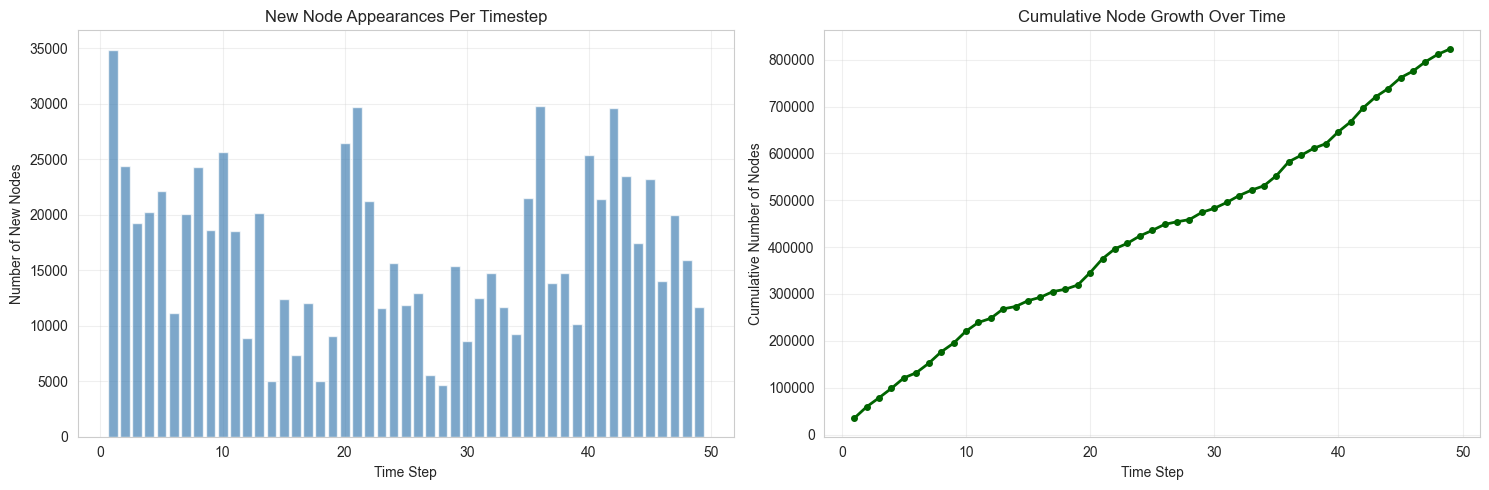

In [8]:
# Visualize node appearance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# New nodes per timestep
ax1.bar(new_nodes_per_timestep['first_timestep'], new_nodes_per_timestep['new_nodes'], alpha=0.7, color='steelblue')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Number of New Nodes')
ax1.set_title('New Node Appearances Per Timestep')
ax1.grid(True, alpha=0.3)

# Cumulative nodes
ax2.plot(new_nodes_per_timestep['first_timestep'], new_nodes_per_timestep['cumulative_nodes'], 
         marker='o', linewidth=2, markersize=4, color='darkgreen')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Cumulative Number of Nodes')
ax2.set_title('Cumulative Node Growth Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2.1. Illicit Node Analysis

Analyze the distribution and characteristics of illicit nodes in the temporal graph.

In [24]:
# Merge first appearance with node classes
first_appearance_with_class = first_appearance.merge(
    nodes_df[['address', 'class']].drop_duplicates(),
    on='address',
    how='left'
)

# Count illicit vs licit vs unknown nodes per timestep
nodes_by_class_timestep = first_appearance_with_class.groupby(['first_timestep', 'class']).size().reset_index(name='count')
nodes_by_class_pivot = nodes_by_class_timestep.pivot(index='first_timestep', columns='class', values='count').fillna(0)

# Rename columns for clarity
class_labels = {1: 'illicit', 2: 'licit', 3: 'unknown'}
nodes_by_class_pivot.columns = [class_labels.get(int(col), f'class_{col}') for col in nodes_by_class_pivot.columns]

# Calculate percentages
nodes_by_class_pct = nodes_by_class_pivot.div(nodes_by_class_pivot.sum(axis=1), axis=0) * 100

print("New nodes by class per timestep (first 10 timesteps):")
print(nodes_by_class_pivot.head(10))
print("\nPercentages:")
print(nodes_by_class_pct.head(10))

New nodes by class per timestep (first 10 timesteps):
                illicit  licit  unknown
first_timestep                         
1                    73  19467    15313
2                    70  14612     9701
3                    45   3308    15921
4                   199   5706    14292
5                    39   7855    14264
6                     9   1427     9684
7                   259   5767    14040
8                   124  13295    10896
9                   394   2814    15409
10                   30   4538    21088

Percentages:
                 illicit      licit    unknown
first_timestep                                
1               0.209451  55.854589  43.935960
2               0.287085  59.926998  39.785916
3               0.233475  17.163018  82.603507
4               0.985295  28.251721  70.762985
5               0.176009  35.449950  64.374041
6               0.080935  12.832734  87.086331
7               1.290741  28.740157  69.969102
8               0.509973  54.

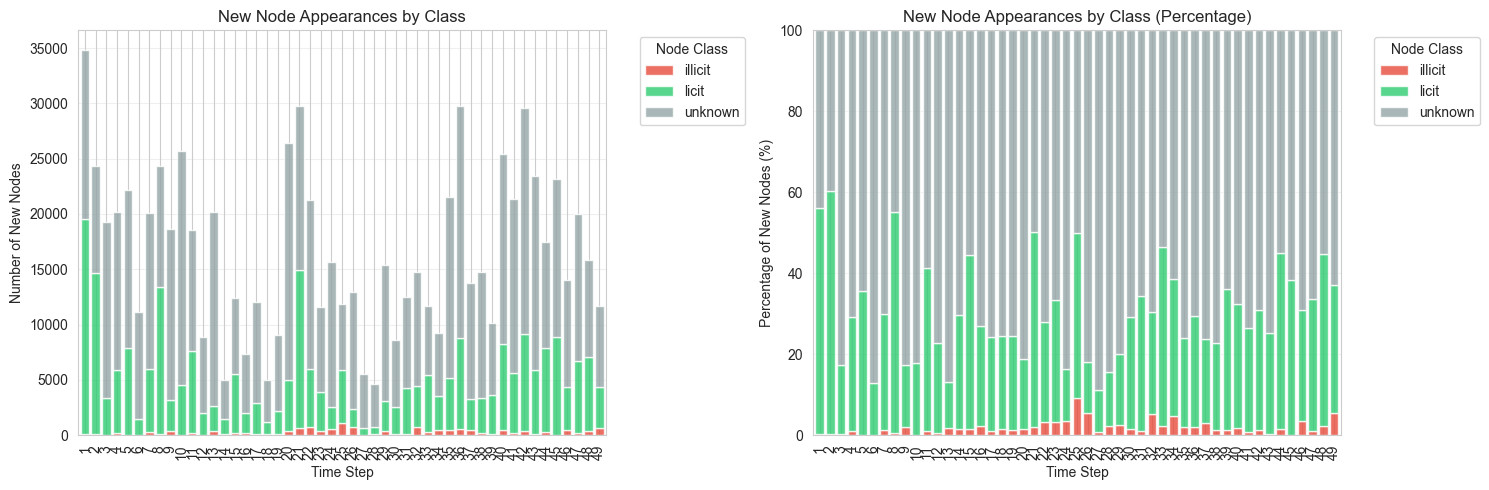

In [25]:
# Visualize illicit node appearance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Stacked bar chart - absolute counts
nodes_by_class_pivot.plot(kind='bar', stacked=True, ax=ax1, alpha=0.8, width=0.8, 
                           color=['#e74c3c', '#2ecc71', '#95a5a6'])
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Number of New Nodes')
ax1.set_title('New Node Appearances by Class')
ax1.legend(title='Node Class', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')

# Percentage stacked bar chart
nodes_by_class_pct.plot(kind='bar', stacked=True, ax=ax2, alpha=0.8, width=0.8,
                         color=['#e74c3c', '#2ecc71', '#95a5a6'])
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Percentage of New Nodes (%)')
ax2.set_title('New Node Appearances by Class (Percentage)')
ax2.legend(title='Node Class', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [26]:
# Overall illicit node statistics
total_nodes = len(first_appearance_with_class)
illicit_nodes = (first_appearance_with_class['class'] == 1).sum()
licit_nodes = (first_appearance_with_class['class'] == 2).sum()
unknown_nodes = (first_appearance_with_class['class'] == 3).sum()

print("\n" + "="*60)
print("ILLICIT NODE STATISTICS")
print("="*60)
print(f"Total nodes: {total_nodes:,}")
print(f"\nNode classification:")
print(f"  Illicit nodes:  {illicit_nodes:6,} ({100*illicit_nodes/total_nodes:5.2f}%)")
print(f"  Licit nodes:    {licit_nodes:6,} ({100*licit_nodes/total_nodes:5.2f}%)")
print(f"  Unknown nodes:  {unknown_nodes:6,} ({100*unknown_nodes/total_nodes:5.2f}%)")

# Average percentage of illicit nodes per timestep
avg_illicit_pct = nodes_by_class_pct['illicit'].mean() if 'illicit' in nodes_by_class_pct.columns else 0
print(f"\nAverage percentage of illicit in new nodes per timestep: {avg_illicit_pct:.2f}%")
print("="*60)


ILLICIT NODE STATISTICS
Total nodes: 822,942

Node classification:
  Illicit nodes:  14,266 ( 1.73%)
  Licit nodes:    251,088 (30.51%)
  Unknown nodes:  557,588 (67.76%)

Average percentage of illicit in new nodes per timestep: 1.96%


## 3. Edge/Transaction Pattern Analysis

Analyze whether transactions occur between:
- New nodes and new nodes
- New nodes and old nodes (existing)
- Old nodes and old nodes

In [9]:
# Create a mapping of address to first appearance time
address_first_time = dict(zip(first_appearance['address'], first_appearance['first_timestep']))

# Analyze edge patterns
edge_patterns = []

for t in tqdm(sorted(edges_df['Time step'].unique()), desc="Analyzing edges"):
    edges_at_t = edges_df[edges_df['Time step'] == t]
    
    for _, edge in edges_at_t.iterrows():
        src = edge['input_address']
        dst = edge['output_address']
        
        src_first = address_first_time.get(src, t)
        dst_first = address_first_time.get(dst, t)
        
        # Classify edge
        src_is_new = (src_first == t)
        dst_is_new = (dst_first == t)
        
        if src_is_new and dst_is_new:
            pattern = 'new-to-new'
        elif src_is_new or dst_is_new:
            pattern = 'new-to-old'
        else:
            pattern = 'old-to-old'
        
        edge_patterns.append({
            'timestep': t,
            'pattern': pattern,
            'src': src,
            'dst': dst,
            'src_age': t - src_first,
            'dst_age': t - dst_first
        })

edge_patterns_df = pd.DataFrame(edge_patterns)
print(f"\nTotal edges analyzed: {len(edge_patterns_df)}")
print(f"\nEdge pattern distribution:")
print(edge_patterns_df['pattern'].value_counts())

Analyzing edges: 100%|██████████| 49/49 [01:00<00:00,  1.24s/it]



Analyzing edges: 100%|██████████| 49/49 [01:00<00:00,  1.24s/it]




Total edges analyzed: 2868964

Edge pattern distribution:
pattern
new-to-new    2262900
new-to-old     506082
old-to-old      99982
Name: count, dtype: int64


In [10]:
# Show concrete examples of each pattern for verification
print("\n" + "="*80)
print("CONCRETE EXAMPLES OF EACH EDGE PATTERN")
print("="*80)

for pattern in ['new-to-new', 'new-to-old', 'old-to-old']:
    print(f"\n{pattern.upper()} Examples:")
    print("-" * 80)
    
    # Get a few examples of this pattern
    examples = edge_patterns_df[edge_patterns_df['pattern'] == pattern].head(3)
    
    for idx, row in examples.iterrows():
        t = row['timestep']
        src = row['src']
        dst = row['dst']
        src_age = row['src_age']
        dst_age = row['dst_age']
        
        print(f"\nExample {idx + 1}:")
        print(f"  Timestep: {t}")
        print(f"  Edge: {src} -> {dst}")
        print(f"  Source node age: {src_age} timesteps (first appeared at t={t - src_age})")
        print(f"  Dest node age: {dst_age} timesteps (first appeared at t={t - dst_age})")
        
        # Verify in original data
        src_first = first_appearance[first_appearance['address'] == src]['first_timestep'].values
        dst_first = first_appearance[first_appearance['address'] == dst]['first_timestep'].values
        
        if len(src_first) > 0 and len(dst_first) > 0:
            print(f"  ✓ Verified: src first seen at t={src_first[0]}, dst first seen at t={dst_first[0]}")
        
print("\n" + "="*80)


CONCRETE EXAMPLES OF EACH EDGE PATTERN

NEW-TO-NEW Examples:
--------------------------------------------------------------------------------

Example 1:
  Timestep: 1
  Edge: 14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a -> 1GASxu5nMntiRKdVtTVRvEbP965G51bhHH
  Source node age: 0 timesteps (first appeared at t=1)
  Dest node age: 0 timesteps (first appeared at t=1)
  ✓ Verified: src first seen at t=1, dst first seen at t=1

Example 2:
  Timestep: 1
  Edge: 14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a -> 14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a
  Source node age: 0 timesteps (first appeared at t=1)
  Dest node age: 0 timesteps (first appeared at t=1)
  ✓ Verified: src first seen at t=1, dst first seen at t=1

Example 3:
  Timestep: 1
  Edge: 13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w -> 1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G
  Source node age: 0 timesteps (first appeared at t=1)
  Dest node age: 0 timesteps (first appeared at t=1)
  ✓ Verified: src first seen at t=1, dst first seen at t=1

NEW-TO-OLD Examples:
-------------

In [11]:
# Pattern distribution over time
pattern_over_time = edge_patterns_df.groupby(['timestep', 'pattern']).size().reset_index(name='count')
pattern_pivot = pattern_over_time.pivot(index='timestep', columns='pattern', values='count').fillna(0)

# Calculate percentages
pattern_pct = pattern_pivot.div(pattern_pivot.sum(axis=1), axis=0) * 100

print("\nPattern percentages (first 10 timesteps):")
print(pattern_pct.head(10))


Pattern percentages (first 10 timesteps):
pattern   new-to-new  new-to-old  old-to-old
timestep                                    
1         100.000000    0.000000    0.000000
2          97.102643    2.376543    0.520814
3          92.310178    6.506654    1.183168
4          89.211970    9.429306    1.358724
5          81.328541   16.270676    2.400783
6          94.151919    4.900626    0.947454
7          79.117998   17.971717    2.910284
8          87.549064   11.211666    1.239270
9          93.038650    5.489045    1.472305
10         64.502464   25.869644    9.627892


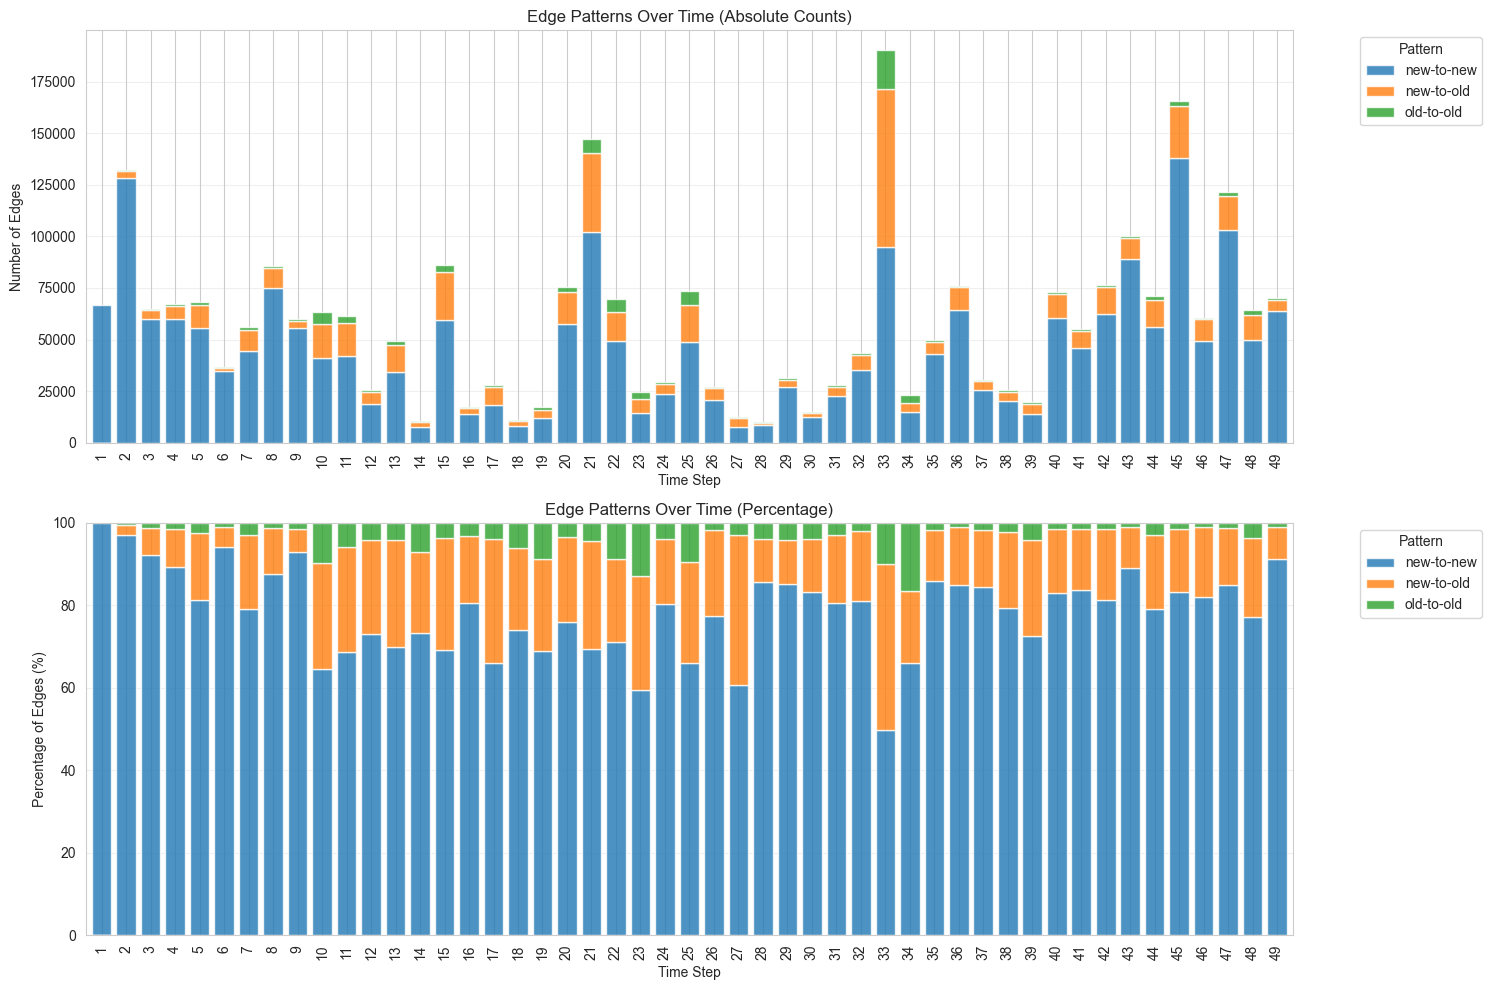

In [12]:
# Visualize edge patterns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Stacked bar chart - absolute counts
pattern_pivot.plot(kind='bar', stacked=True, ax=ax1, alpha=0.8, width=0.8)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Number of Edges')
ax1.set_title('Edge Patterns Over Time (Absolute Counts)')
ax1.legend(title='Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')

# Stacked bar chart - percentages
pattern_pct.plot(kind='bar', stacked=True, ax=ax2, alpha=0.8, width=0.8)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Percentage of Edges (%)')
ax2.set_title('Edge Patterns Over Time (Percentage)')
ax2.legend(title='Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

## 3.1. Edge Patterns for Illicit Nodes

Analyze transaction patterns specifically involving illicit nodes.

In [30]:
# Classify edges by illicit node involvement
# Get illicit addresses
illicit_addresses = set(first_appearance_with_class[first_appearance_with_class['class'] == 1]['address'])

# Add illicit classification to edge patterns
edge_patterns_df['src_is_illicit'] = edge_patterns_df['src'].isin(illicit_addresses)
edge_patterns_df['dst_is_illicit'] = edge_patterns_df['dst'].isin(illicit_addresses)

# Classify edge by illicit involvement
def classify_illicit_edge(row):
    if row['src_is_illicit'] and row['dst_is_illicit']:
        return 'illicit-to-illicit'
    elif row['src_is_illicit']:
        return 'illicit-to-other'
    elif row['dst_is_illicit']:
        return 'other-to-illicit'
    else:
        return 'no-illicit'

edge_patterns_df['illicit_pattern'] = edge_patterns_df.apply(classify_illicit_edge, axis=1)

# Count patterns
illicit_pattern_counts = edge_patterns_df['illicit_pattern'].value_counts()

print("\n" + "="*70)
print("EDGE PATTERNS BY ILLICIT INVOLVEMENT")
print("="*70)
print(f"\nTotal edges: {len(edge_patterns_df):,}")
print("\nEdge distribution:")
for pattern, count in illicit_pattern_counts.items():
    pct = 100 * count / len(edge_patterns_df)
    print(f"  {pattern:20s}: {count:8,} ({pct:5.2f}%)")

# Breakdown by new/old pattern for illicit edges
print("\n" + "-"*70)
print("ILLICIT EDGES BY NEW/OLD PATTERN")
print("-"*70)

illicit_edges = edge_patterns_df[edge_patterns_df['illicit_pattern'] != 'no-illicit']
if len(illicit_edges) > 0:
    illicit_by_pattern = illicit_edges.groupby(['illicit_pattern', 'pattern']).size().reset_index(name='count')
    for illicit_type in ['illicit-to-illicit', 'illicit-to-other', 'other-to-illicit']:
        subset = illicit_by_pattern[illicit_by_pattern['illicit_pattern'] == illicit_type]
        if len(subset) > 0:
            total_type = subset['count'].sum()
            print(f"\n{illicit_type.upper()}:")
            for _, row in subset.iterrows():
                pct = 100 * row['count'] / total_type
                print(f"  {row['pattern']:15s}: {row['count']:6,} ({pct:5.1f}%)")

print("="*70)


EDGE PATTERNS BY ILLICIT INVOLVEMENT

Total edges: 2,868,964

Edge distribution:
  no-illicit          : 2,832,061 (98.71%)
  other-to-illicit    :   18,760 ( 0.65%)
  illicit-to-illicit  :   15,996 ( 0.56%)
  illicit-to-other    :    2,147 ( 0.07%)

----------------------------------------------------------------------
ILLICIT EDGES BY NEW/OLD PATTERN
----------------------------------------------------------------------

ILLICIT-TO-ILLICIT:
  new-to-new     : 13,888 ( 86.8%)
  new-to-old     :  1,621 ( 10.1%)
  old-to-old     :    487 (  3.0%)

ILLICIT-TO-OTHER:
  new-to-new     :  1,789 ( 83.3%)
  new-to-old     :    324 ( 15.1%)
  old-to-old     :     34 (  1.6%)

OTHER-TO-ILLICIT:
  new-to-new     : 15,601 ( 83.2%)
  new-to-old     :  3,120 ( 16.6%)
  old-to-old     :     39 (  0.2%)


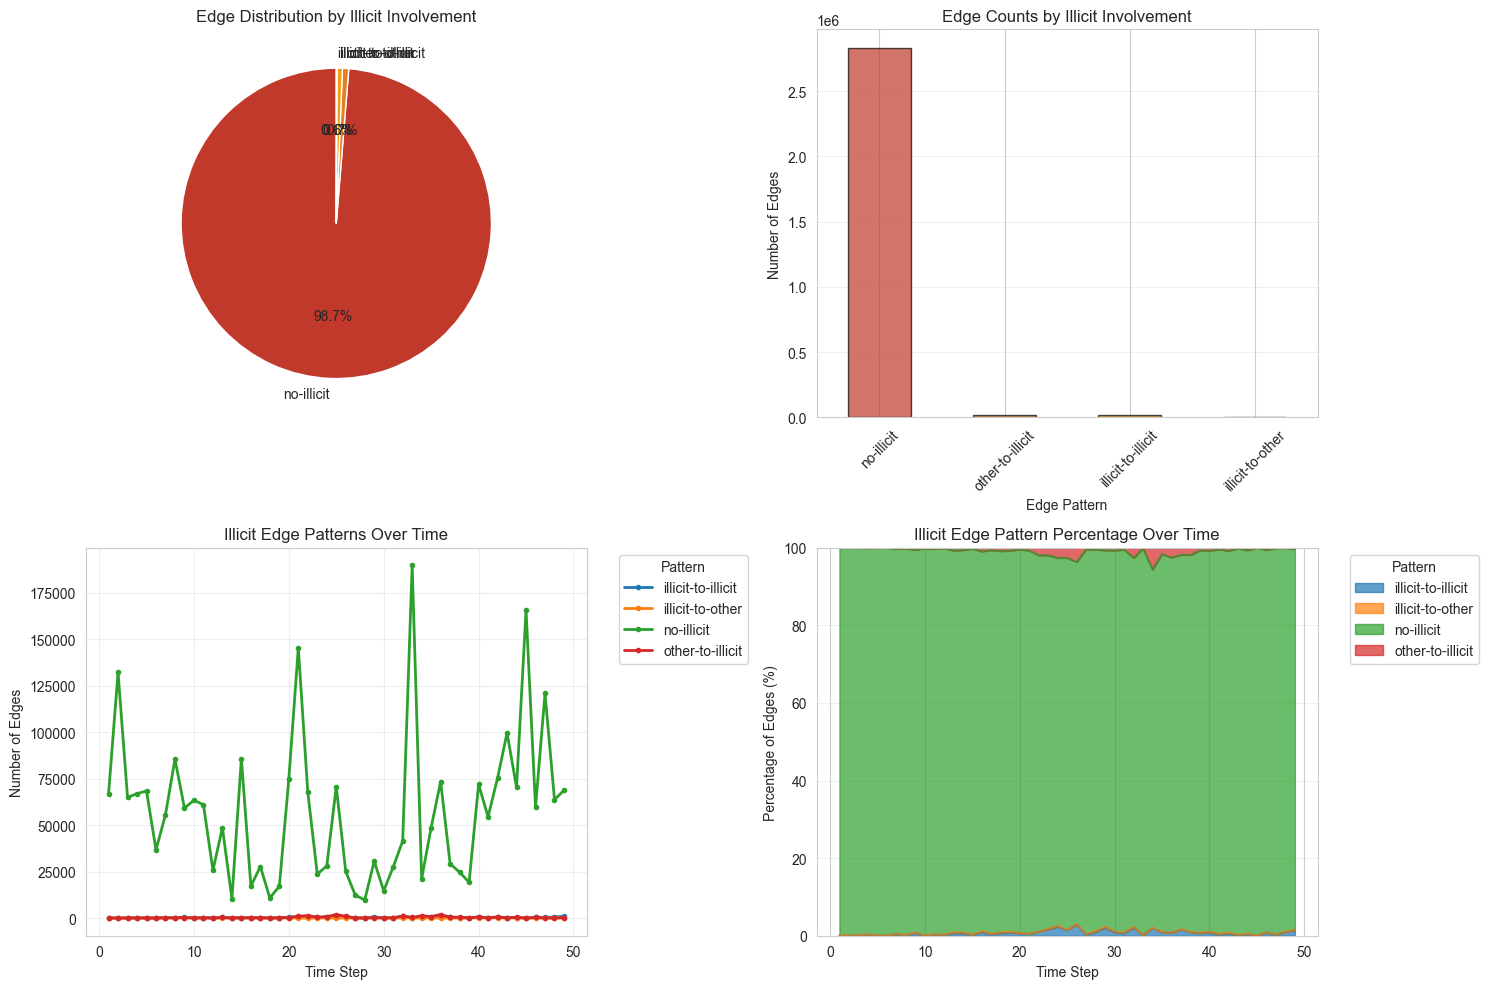

In [31]:
# Visualize illicit edge patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Pie chart of illicit involvement
ax1 = axes[0, 0]
colors_illicit = ['#c0392b', '#e67e22', '#f39c12', '#95a5a6']
illicit_pattern_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%', colors=colors_illicit, startangle=90)
ax1.set_ylabel('')
ax1.set_title('Edge Distribution by Illicit Involvement')

# Bar chart comparison
ax2 = axes[0, 1]
illicit_pattern_counts.plot(kind='bar', ax=ax2, color=colors_illicit, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Edge Pattern')
ax2.set_ylabel('Number of Edges')
ax2.set_title('Edge Counts by Illicit Involvement')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Time series of illicit edges
ax3 = axes[1, 0]
illicit_edges_over_time = edge_patterns_df.groupby(['timestep', 'illicit_pattern']).size().reset_index(name='count')
illicit_pivot = illicit_edges_over_time.pivot(index='timestep', columns='illicit_pattern', values='count').fillna(0)
illicit_pivot.plot(kind='line', ax=ax3, linewidth=2, marker='o', markersize=3)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Number of Edges')
ax3.set_title('Illicit Edge Patterns Over Time')
ax3.legend(title='Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Stacked percentage over time
ax4 = axes[1, 1]
illicit_pct = illicit_pivot.div(illicit_pivot.sum(axis=1), axis=0) * 100
illicit_pct.plot(kind='area', ax=ax4, alpha=0.7, stacked=True)
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Percentage of Edges (%)')
ax4.set_title('Illicit Edge Pattern Percentage Over Time')
ax4.legend(title='Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.set_ylim(0, 100)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [32]:
# Detailed analysis: What do illicit nodes typically connect to?
print("\n" + "="*70)
print("ILLICIT NODE CONNECTION PATTERNS")
print("="*70)

# For illicit source nodes
illicit_src_edges = edge_patterns_df[edge_patterns_df['src_is_illicit']]
if len(illicit_src_edges) > 0:
    print(f"\nWhen ILLICIT nodes are SOURCES (n={len(illicit_src_edges):,} edges):")
    to_illicit = (illicit_src_edges['dst_is_illicit']).sum()
    to_other = len(illicit_src_edges) - to_illicit
    print(f"  To illicit nodes:  {to_illicit:8,} ({100*to_illicit/len(illicit_src_edges):5.1f}%)")
    print(f"  To other nodes:    {to_other:8,} ({100*to_other/len(illicit_src_edges):5.1f}%)")
    
    # New/old pattern
    print(f"\n  By new/old pattern:")
    src_patterns = illicit_src_edges['pattern'].value_counts()
    for pattern, count in src_patterns.items():
        pct = 100 * count / len(illicit_src_edges)
        print(f"    {pattern:15s}: {count:6,} ({pct:5.1f}%)")

# For illicit destination nodes
illicit_dst_edges = edge_patterns_df[edge_patterns_df['dst_is_illicit']]
if len(illicit_dst_edges) > 0:
    print(f"\nWhen ILLICIT nodes are DESTINATIONS (n={len(illicit_dst_edges):,} edges):")
    from_illicit = (illicit_dst_edges['src_is_illicit']).sum()
    from_other = len(illicit_dst_edges) - from_illicit
    print(f"  From illicit nodes: {from_illicit:8,} ({100*from_illicit/len(illicit_dst_edges):5.1f}%)")
    print(f"  From other nodes:   {from_other:8,} ({100*from_other/len(illicit_dst_edges):5.1f}%)")
    
    # New/old pattern
    print(f"\n  By new/old pattern:")
    dst_patterns = illicit_dst_edges['pattern'].value_counts()
    for pattern, count in dst_patterns.items():
        pct = 100 * count / len(illicit_dst_edges)
        print(f"    {pattern:15s}: {count:6,} ({pct:5.1f}%)")

# Illicit-to-illicit connections
illicit_to_illicit = edge_patterns_df[
    edge_patterns_df['src_is_illicit'] & edge_patterns_df['dst_is_illicit']
]
if len(illicit_to_illicit) > 0:
    print(f"\nILLICIT-TO-ILLICIT CONNECTIONS (n={len(illicit_to_illicit):,} edges):")
    print(f"  By new/old pattern:")
    i2i_patterns = illicit_to_illicit['pattern'].value_counts()
    for pattern, count in i2i_patterns.items():
        pct = 100 * count / len(illicit_to_illicit)
        print(f"    {pattern:15s}: {count:6,} ({pct:5.1f}%)")

print("="*70)


ILLICIT NODE CONNECTION PATTERNS

When ILLICIT nodes are SOURCES (n=18,143 edges):
  To illicit nodes:    15,996 ( 88.2%)
  To other nodes:       2,147 ( 11.8%)

  By new/old pattern:
    new-to-new     : 15,677 ( 86.4%)
    new-to-old     :  1,945 ( 10.7%)
    old-to-old     :    521 (  2.9%)

When ILLICIT nodes are DESTINATIONS (n=34,756 edges):
  From illicit nodes:   15,996 ( 46.0%)
  From other nodes:     18,760 ( 54.0%)

  By new/old pattern:
    new-to-new     : 29,489 ( 84.8%)
    new-to-old     :  4,741 ( 13.6%)
    old-to-old     :    526 (  1.5%)

ILLICIT-TO-ILLICIT CONNECTIONS (n=15,996 edges):
  By new/old pattern:
    new-to-new     : 13,888 ( 86.8%)
    new-to-old     :  1,621 ( 10.1%)
    old-to-old     :    487 (  3.0%)


## 4. Node Activity Analysis

Analyze how many transactions each node participates in and whether they are concentrated in time.

In [13]:
print("Analyzing node activity with vectorized operations...")

# Create a melted view of edges (both source and destination as 'address')
src_edges = edges_df[['input_address', 'Time step']].rename(columns={'input_address': 'address'})
dst_edges = edges_df[['output_address', 'Time step']].rename(columns={'output_address': 'address'})
melted = pd.concat([src_edges, dst_edges], ignore_index=True)

# Count total transactions and active timesteps per address
activity_basic = melted.groupby('address').agg(
    total_transactions=('Time step', 'count'),
    num_active_timesteps=('Time step', 'nunique')
).reset_index()

# Count transactions as source
as_source = edges_df.groupby('input_address').size().rename('as_source')

# Count transactions as destination
as_destination = edges_df.groupby('output_address').size().rename('as_destination')

# Merge all together
node_activity_df = activity_basic.merge(
    as_source, left_on='address', right_index=True, how='left'
).merge(
    as_destination, left_on='address', right_index=True, how='left'
)

# Fill NaN values with 0 (for addresses that only appear as source or destination)
node_activity_df['as_source'] = node_activity_df['as_source'].fillna(0).astype(int)
node_activity_df['as_destination'] = node_activity_df['as_destination'].fillna(0).astype(int)

# Add first appearance info
node_activity_df['first_appearance'] = node_activity_df['address'].map(address_first_time)

print(f"\nNode activity stats:")
print(node_activity_df.describe())

Analyzing node activity with vectorized operations...

Node activity stats:
       total_transactions  num_active_timesteps      as_source  \
count       822942.000000         822942.000000  822942.000000   
mean             6.972457              1.118780       3.486229   
std             66.309278              0.571136      59.775630   
min              1.000000              1.000000       0.000000   
25%              1.000000              1.000000       0.000000   
50%              2.000000              1.000000       0.000000   
75%              4.000000              1.000000       2.000000   
max          37841.000000             47.000000   37835.000000   

       as_destination  first_appearance  
count   822942.000000     822942.000000  
mean         3.486229         24.519890  
std         23.551525         15.215729  
min          0.000000          1.000000  
25%          1.000000         10.000000  
50%          1.000000         24.000000  
75%          2.000000         39.00

In [16]:
# Distribution of transaction counts
print("\nTransaction count distribution:")
print(node_activity_df['total_transactions'].value_counts().sort_index().head(20))


Transaction count distribution:
total_transactions
1     282222
2     193965
3     126907
4      43455
5      23163
6      18683
7      15328
8      10171
9      11862
10      9877
11      5649
12      6901
13      3682
14      3244
15      3490
16      3932
17      4048
18      3529
19      2238
20      1950
Name: count, dtype: int64


In [27]:
# Merge node activity with class information
node_activity_with_class = node_activity_df.merge(
    nodes_df[['address', 'class']].drop_duplicates(),
    on='address',
    how='left'
)

# Separate by class
illicit_activity = node_activity_with_class[node_activity_with_class['class'] == 1]
licit_activity = node_activity_with_class[node_activity_with_class['class'] == 2]
unknown_activity = node_activity_with_class[node_activity_with_class['class'] == 3]

print("\n" + "="*70)
print("TRANSACTION ACTIVITY BY NODE CLASS")
print("="*70)

print(f"\nILLICIT NODES (n={len(illicit_activity):,}):")
print(f"  Average transactions: {illicit_activity['total_transactions'].mean():.2f}")
print(f"  Median transactions:  {illicit_activity['total_transactions'].median():.1f}")
print(f"  Max transactions:     {illicit_activity['total_transactions'].max()}")
print(f"  Average active timesteps: {illicit_activity['num_active_timesteps'].mean():.2f}")

print(f"\nLICIT NODES (n={len(licit_activity):,}):")
print(f"  Average transactions: {licit_activity['total_transactions'].mean():.2f}")
print(f"  Median transactions:  {licit_activity['total_transactions'].median():.1f}")
print(f"  Max transactions:     {licit_activity['total_transactions'].max()}")
print(f"  Average active timesteps: {licit_activity['num_active_timesteps'].mean():.2f}")

print(f"\nUNKNOWN NODES (n={len(unknown_activity):,}):")
print(f"  Average transactions: {unknown_activity['total_transactions'].mean():.2f}")
print(f"  Median transactions:  {unknown_activity['total_transactions'].median():.1f}")
print(f"  Max transactions:     {unknown_activity['total_transactions'].max()}")
print(f"  Average active timesteps: {unknown_activity['num_active_timesteps'].mean():.2f}")

# Comparison
illicit_vs_licit_ratio = illicit_activity['total_transactions'].mean() / licit_activity['total_transactions'].mean()
print(f"\nIllicit vs Licit transaction ratio: {illicit_vs_licit_ratio:.2f}x")
print("="*70)


TRANSACTION ACTIVITY BY NODE CLASS

ILLICIT NODES (n=14,266):
  Average transactions: 3.71
  Median transactions:  2.0
  Max transactions:     1999
  Average active timesteps: 1.03

LICIT NODES (n=251,088):
  Average transactions: 10.86
  Median transactions:  2.0
  Max transactions:     37841
  Average active timesteps: 1.10

UNKNOWN NODES (n=557,588):
  Average transactions: 5.30
  Median transactions:  2.0
  Max transactions:     12145
  Average active timesteps: 1.13

Illicit vs Licit transaction ratio: 0.34x


C:\Users\rowde\AppData\Local\Temp\ipykernel_19088\4107302086.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data_to_plot, labels=['Illicit', 'Licit', 'Unknown'])
C:\Users\rowde\AppData\Local\Temp\ipykernel_19088\4107302086.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(data_to_plot_timesteps, labels=['Illicit', 'Licit', 'Unknown'])


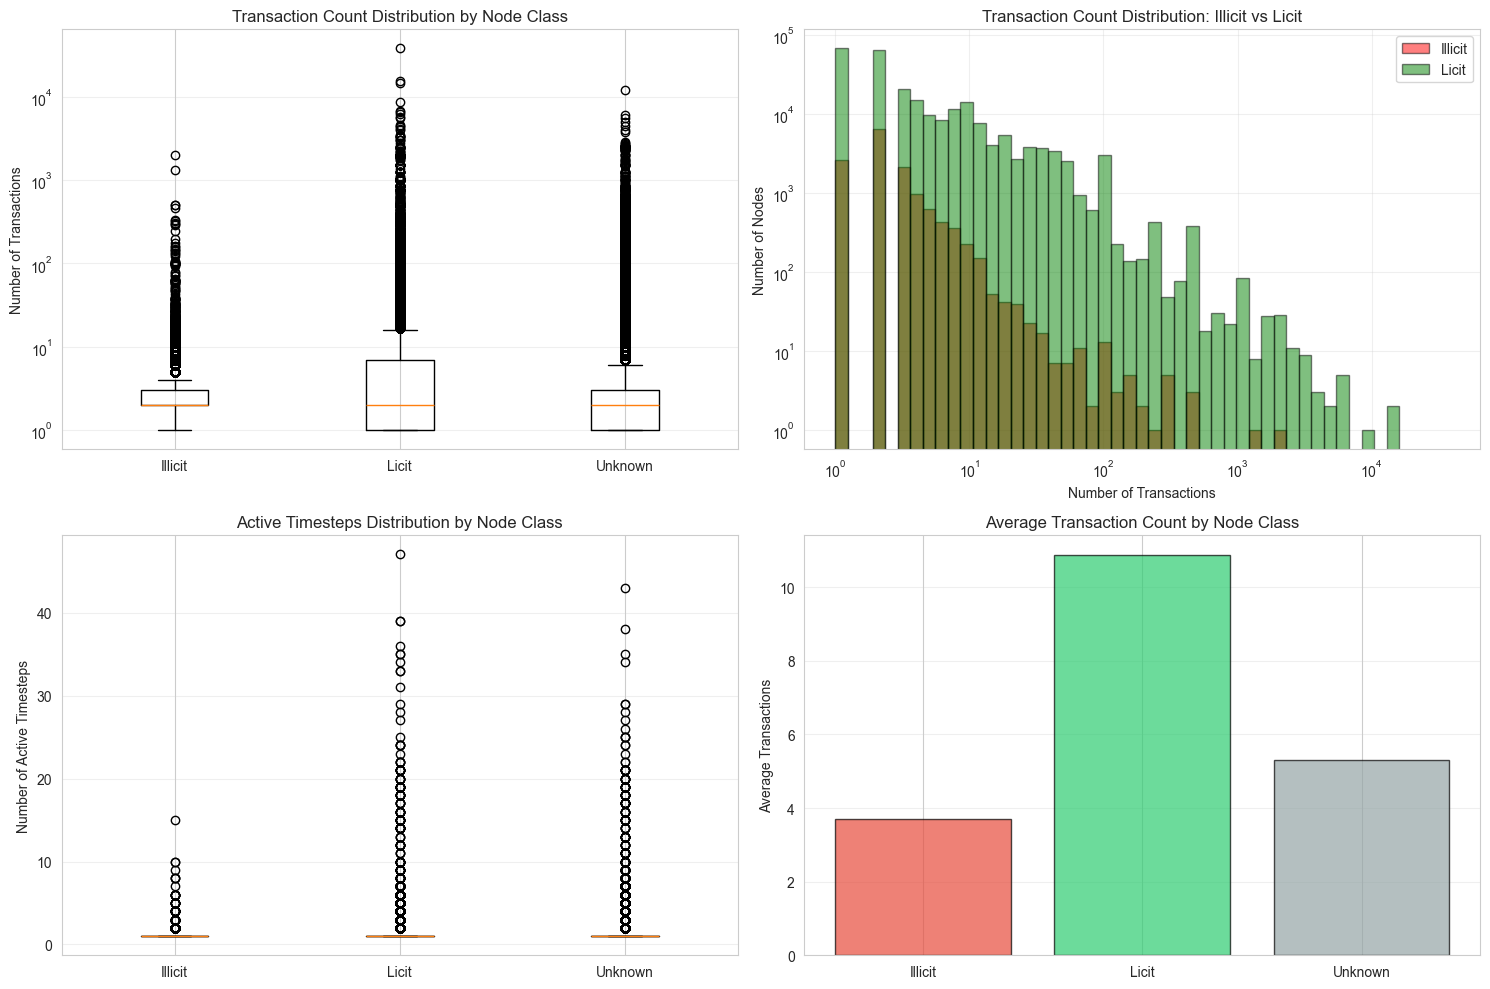

In [28]:
# Visualize transaction distribution by class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Transaction count comparison
ax1 = axes[0, 0]
data_to_plot = [
    illicit_activity['total_transactions'],
    licit_activity['total_transactions'],
    unknown_activity['total_transactions']
]
ax1.boxplot(data_to_plot, labels=['Illicit', 'Licit', 'Unknown'])
ax1.set_ylabel('Number of Transactions')
ax1.set_title('Transaction Count Distribution by Node Class')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, axis='y')

# Histogram overlay
ax2 = axes[0, 1]
bins = np.logspace(0, np.log10(node_activity_with_class['total_transactions'].max()), 50)
ax2.hist(illicit_activity['total_transactions'], bins=bins, alpha=0.5, label='Illicit', color='red', edgecolor='black')
ax2.hist(licit_activity['total_transactions'], bins=bins, alpha=0.5, label='Licit', color='green', edgecolor='black')
ax2.set_xlabel('Number of Transactions')
ax2.set_ylabel('Number of Nodes')
ax2.set_title('Transaction Count Distribution: Illicit vs Licit')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Active timesteps comparison
ax3 = axes[1, 0]
data_to_plot_timesteps = [
    illicit_activity['num_active_timesteps'],
    licit_activity['num_active_timesteps'],
    unknown_activity['num_active_timesteps']
]
ax3.boxplot(data_to_plot_timesteps, labels=['Illicit', 'Licit', 'Unknown'])
ax3.set_ylabel('Number of Active Timesteps')
ax3.set_title('Active Timesteps Distribution by Node Class')
ax3.grid(True, alpha=0.3, axis='y')

# Bar chart of averages
ax4 = axes[1, 1]
classes = ['Illicit', 'Licit', 'Unknown']
avg_transactions = [
    illicit_activity['total_transactions'].mean(),
    licit_activity['total_transactions'].mean(),
    unknown_activity['total_transactions'].mean()
]
colors_bar = ['#e74c3c', '#2ecc71', '#95a5a6']
ax4.bar(classes, avg_transactions, color=colors_bar, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Average Transactions')
ax4.set_title('Average Transaction Count by Node Class')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

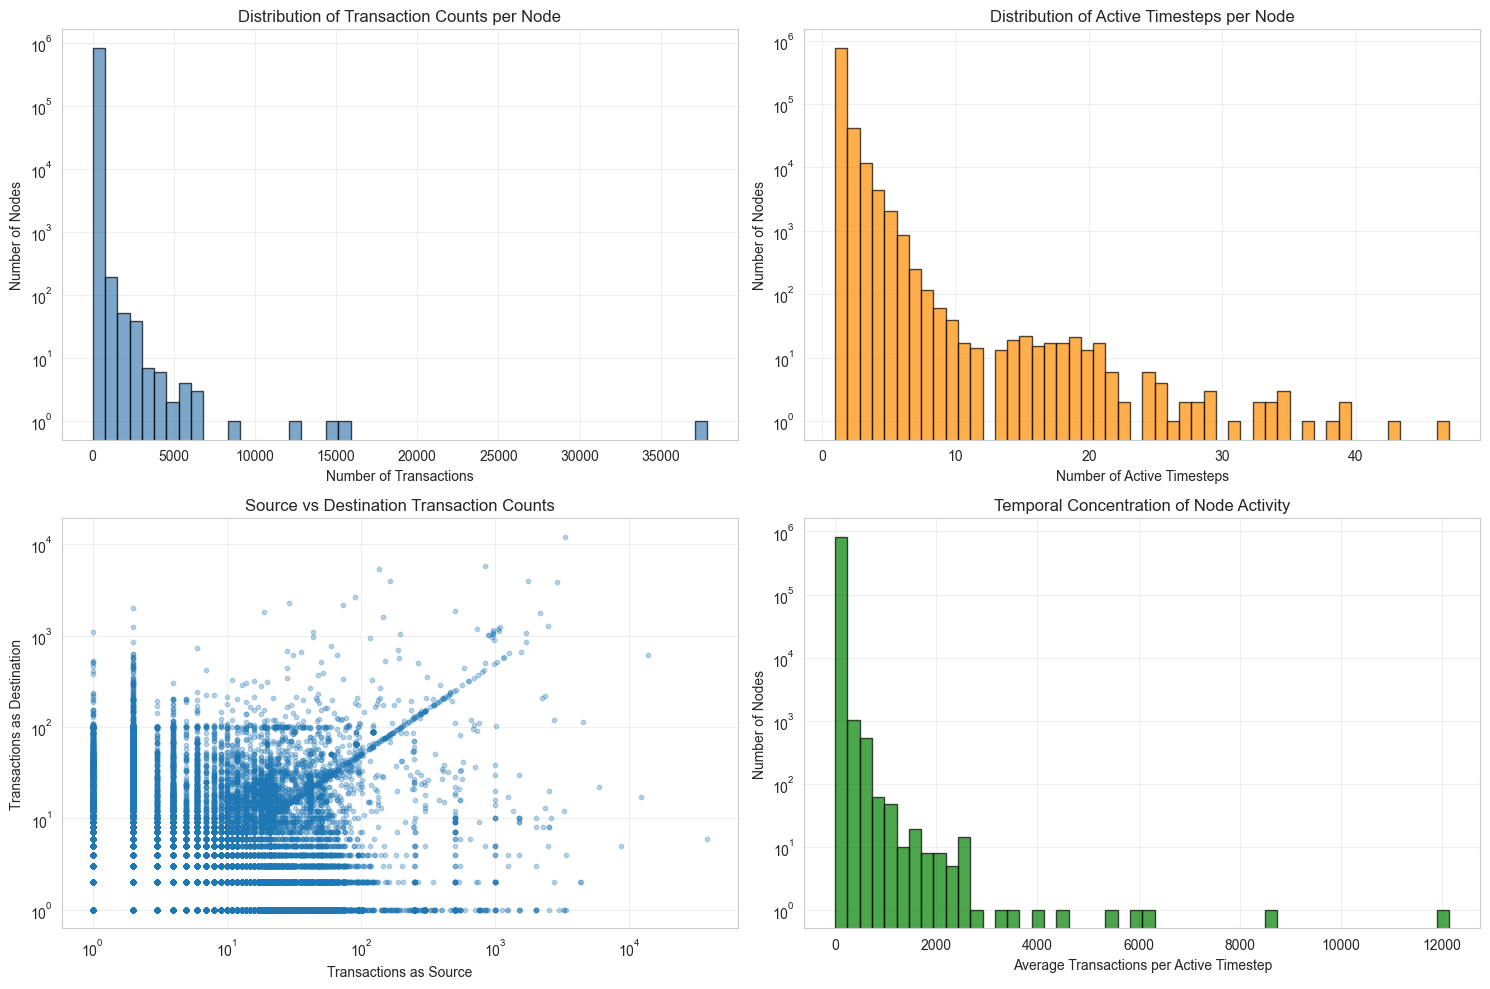

In [17]:
# Visualize transaction count distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total transactions histogram
ax1 = axes[0, 0]
node_activity_df['total_transactions'].hist(bins=50, ax=ax1, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Transactions')
ax1.set_ylabel('Number of Nodes')
ax1.set_title('Distribution of Transaction Counts per Node')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Active timesteps histogram
ax2 = axes[0, 1]
node_activity_df['num_active_timesteps'].hist(bins=50, ax=ax2, alpha=0.7, color='darkorange', edgecolor='black')
ax2.set_xlabel('Number of Active Timesteps')
ax2.set_ylabel('Number of Nodes')
ax2.set_title('Distribution of Active Timesteps per Node')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Source vs destination transactions
ax3 = axes[1, 0]
ax3.scatter(node_activity_df['as_source'], node_activity_df['as_destination'], alpha=0.3, s=10)
ax3.set_xlabel('Transactions as Source')
ax3.set_ylabel('Transactions as Destination')
ax3.set_title('Source vs Destination Transaction Counts')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Temporal concentration: transactions per active timestep
ax4 = axes[1, 1]
node_activity_df['tx_per_active_timestep'] = (
    node_activity_df['total_transactions'] / node_activity_df['num_active_timesteps']
)
node_activity_df['tx_per_active_timestep'].hist(bins=50, ax=ax4, alpha=0.7, color='green', edgecolor='black')
ax4.set_xlabel('Average Transactions per Active Timestep')
ax4.set_ylabel('Number of Nodes')
ax4.set_title('Temporal Concentration of Node Activity')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Key statistics
single_tx_nodes = (node_activity_df['total_transactions'] == 1).sum()
multi_tx_nodes = (node_activity_df['total_transactions'] > 1).sum()
single_timestep_nodes = (node_activity_df['num_active_timesteps'] == 1).sum()
multi_timestep_nodes = (node_activity_df['num_active_timesteps'] > 1).sum()

print("\n" + "="*60)
print("KEY STATISTICS")
print("="*60)
print(f"Total nodes with transactions: {len(node_activity_df)}")
print(f"\nTransaction frequency:")
print(f"  Nodes with single transaction:    {single_tx_nodes:6d} ({100*single_tx_nodes/len(node_activity_df):.1f}%)")
print(f"  Nodes with multiple transactions: {multi_tx_nodes:6d} ({100*multi_tx_nodes/len(node_activity_df):.1f}%)")
print(f"\nTemporal concentration:")
print(f"  Nodes active in single timestep:  {single_timestep_nodes:6d} ({100*single_timestep_nodes/len(node_activity_df):.1f}%)")
print(f"  Nodes active in multiple timesteps: {multi_timestep_nodes:6d} ({100*multi_timestep_nodes/len(node_activity_df):.1f}%)")
print(f"\nAverage transactions per node: {node_activity_df['total_transactions'].mean():.2f}")
print(f"Average active timesteps per node: {node_activity_df['num_active_timesteps'].mean():.2f}")
print(f"Average transactions per active timestep: {node_activity_df['tx_per_active_timestep'].mean():.2f}")
print("="*60)


KEY STATISTICS
Total nodes with transactions: 822942

Transaction frequency:
  Nodes with single transaction:    282222 (34.3%)
  Nodes with multiple transactions: 540720 (65.7%)

Temporal concentration:
  Nodes active in single timestep:  761455 (92.5%)
  Nodes active in multiple timesteps:  61487 (7.5%)

Average transactions per node: 6.97
Average active timesteps per node: 1.12
Average transactions per active timestep: 6.12


## 5. Same-Timestep Multiple Transaction Analysis

Analyze nodes that have multiple transactions within the same timestep.

In [19]:
print("Analyzing same-timestep activity with vectorized operations...")

# Use the melted dataframe from previous cell (or recreate if needed)
if 'melted' not in locals():
    src_edges = edges_df[['input_address', 'Time step']].rename(columns={'input_address': 'address'})
    dst_edges = edges_df[['output_address', 'Time step']].rename(columns={'output_address': 'address'})
    melted = pd.concat([src_edges, dst_edges], ignore_index=True)

# Count transactions per address per timestep
addr_timestep_counts = melted.groupby(['address', 'Time step']).size().reset_index(name='tx_count')

# For each address, find max transactions in a single timestep
max_tx_per_timestep = addr_timestep_counts.groupby('address').agg(
    total_active_timesteps=('Time step', 'nunique'),
    max_tx_in_single_timestep=('tx_count', 'max'),
    timesteps_with_multiple_tx=('tx_count', lambda x: (x > 1).sum())
).reset_index()

# Add boolean flag
max_tx_per_timestep['has_multi_tx_same_timestep'] = max_tx_per_timestep['timesteps_with_multiple_tx'] > 0

multi_tx_df = max_tx_per_timestep

print(f"\nSame-timestep multiple transaction stats:")
print(multi_tx_df.describe())

Analyzing same-timestep activity with vectorized operations...

Same-timestep multiple transaction stats:
       total_active_timesteps  max_tx_in_single_timestep  \
count           822942.000000              822942.000000   
mean                 1.118780                   6.474856   
std                  0.571136                  41.939503   
min                  1.000000                   1.000000   
25%                  1.000000                   1.000000   
50%                  1.000000                   2.000000   
75%                  1.000000                   3.000000   
max                 47.000000               13108.000000   

       timesteps_with_multiple_tx  
count               822942.000000  
mean                     0.671176  
std                      0.627101  
min                      0.000000  
25%                      0.000000  
50%                      1.000000  
75%                      1.000000  
max                     46.000000  

Same-timestep multiple trans

In [20]:
# Statistics
has_multi = multi_tx_df['has_multi_tx_same_timestep'].sum()
no_multi = len(multi_tx_df) - has_multi

print("\n" + "="*60)
print("SAME-TIMESTEP MULTIPLE TRANSACTION ANALYSIS")
print("="*60)
print(f"Nodes with multiple transactions in same timestep: {has_multi:6d} ({100*has_multi/len(multi_tx_df):.1f}%)")
print(f"Nodes with only single transactions per timestep: {no_multi:6d} ({100*no_multi/len(multi_tx_df):.1f}%)")
print(f"\nMax transactions in a single timestep: {multi_tx_df['max_tx_in_single_timestep'].max()}")
print(f"Average max transactions in a single timestep: {multi_tx_df['max_tx_in_single_timestep'].mean():.2f}")
print("="*60)


SAME-TIMESTEP MULTIPLE TRANSACTION ANALYSIS
Nodes with multiple transactions in same timestep: 520958 (63.3%)
Nodes with only single transactions per timestep: 301984 (36.7%)

Max transactions in a single timestep: 13108
Average max transactions in a single timestep: 6.47


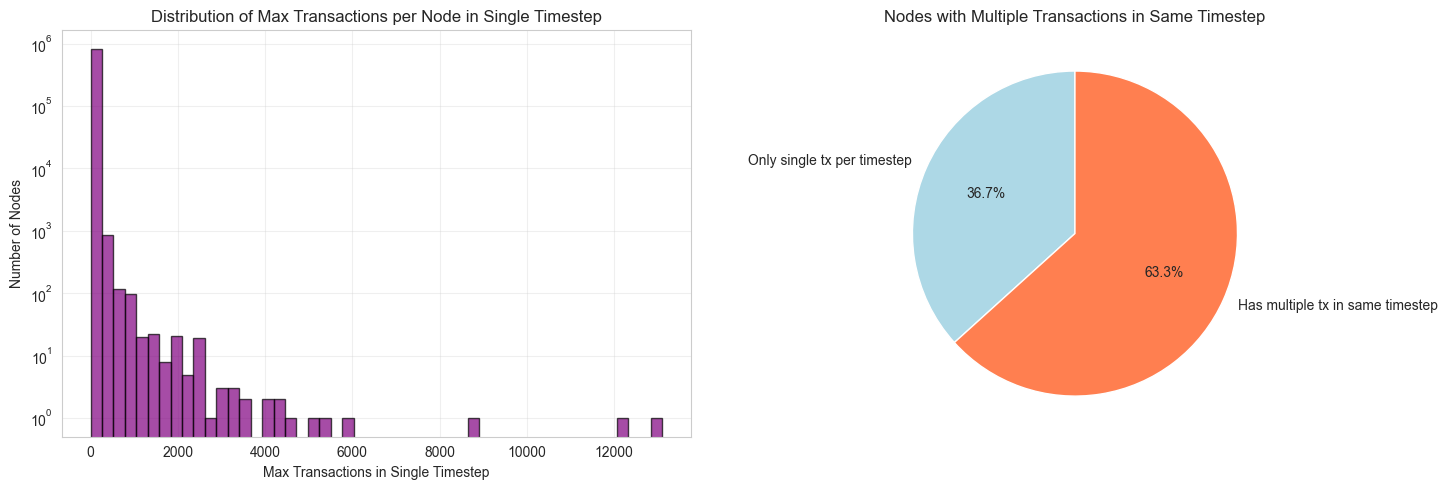

In [21]:
# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of max transactions in single timestep
ax1.hist(multi_tx_df['max_tx_in_single_timestep'], bins=50, alpha=0.7, color='purple', edgecolor='black')
ax1.set_xlabel('Max Transactions in Single Timestep')
ax1.set_ylabel('Number of Nodes')
ax1.set_title('Distribution of Max Transactions per Node in Single Timestep')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Pie chart
labels = ['Only single tx per timestep', 'Has multiple tx in same timestep']
sizes = [no_multi, has_multi]
colors = ['lightblue', 'coral']
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Nodes with Multiple Transactions in Same Timestep')

plt.tight_layout()
plt.show()

## 6. Summary Report

In [29]:
# Generate comprehensive summary
print("\n" + "="*80)
print("TEMPORAL GRAPH ANALYSIS SUMMARY")
print("="*80)

print("\n1. GRAPH SCALE")
print("-" * 80)
print(f"   Total unique nodes: {len(first_appearance):,}")
print(f"   Total edges: {len(edges_df):,}")
print(f"   Time steps: {edges_df['Time step'].min()} to {edges_df['Time step'].max()}")
print(f"   Average nodes per timestep: {new_nodes_per_timestep['new_nodes'].mean():.1f}")
print(f"   Average edges per timestep: {len(edges_df) / edges_df['Time step'].nunique():.1f}")

print("\n2. NODE APPEARANCE PATTERNS")
print("-" * 80)
print(f"   Average new nodes per timestep: {new_nodes_per_timestep['new_nodes'].mean():.1f}")
print(f"   Max new nodes in single timestep: {new_nodes_per_timestep['new_nodes'].max()}")
print(f"   Min new nodes in single timestep: {new_nodes_per_timestep['new_nodes'].min()}")

print("\n2.1. NODE CLASSIFICATION")
print("-" * 80)
print(f"   Illicit nodes:  {illicit_nodes:6,} ({100*illicit_nodes/total_nodes:5.2f}%)")
print(f"   Licit nodes:    {licit_nodes:6,} ({100*licit_nodes/total_nodes:5.2f}%)")
print(f"   Unknown nodes:  {unknown_nodes:6,} ({100*unknown_nodes/total_nodes:5.2f}%)")
avg_illicit_pct = nodes_by_class_pct['illicit'].mean() if 'illicit' in nodes_by_class_pct.columns else 0
print(f"   Avg % illicit in new nodes per timestep: {avg_illicit_pct:.2f}%")

print("\n3. EDGE PATTERNS")
print("-" * 80)
pattern_summary = edge_patterns_df['pattern'].value_counts(normalize=True) * 100
for pattern, pct in pattern_summary.items():
    print(f"   {pattern:15s}: {pct:5.1f}%")

print("\n4. NODE ACTIVITY")
print("-" * 80)
print(f"   Single transaction nodes: {single_tx_nodes:,} ({100*single_tx_nodes/len(node_activity_df):.1f}%)")
print(f"   Multiple transaction nodes: {multi_tx_nodes:,} ({100*multi_tx_nodes/len(node_activity_df):.1f}%)")
print(f"   Average transactions per node: {node_activity_df['total_transactions'].mean():.2f}")
print(f"   Median transactions per node: {node_activity_df['total_transactions'].median():.1f}")
print(f"   Max transactions for single node: {node_activity_df['total_transactions'].max()}")

print("\n4.1. ACTIVITY BY NODE CLASS")
print("-" * 80)
print(f"   Illicit nodes avg transactions: {illicit_activity['total_transactions'].mean():.2f}")
print(f"   Licit nodes avg transactions:   {licit_activity['total_transactions'].mean():.2f}")
print(f"   Unknown nodes avg transactions: {unknown_activity['total_transactions'].mean():.2f}")
illicit_vs_licit_ratio = illicit_activity['total_transactions'].mean() / licit_activity['total_transactions'].mean()
print(f"   Illicit vs Licit ratio: {illicit_vs_licit_ratio:.2f}x")

print("\n5. TEMPORAL CONCENTRATION")
print("-" * 80)
print(f"   Single-timestep active nodes: {single_timestep_nodes:,} ({100*single_timestep_nodes/len(node_activity_df):.1f}%)")
print(f"   Multi-timestep active nodes: {multi_timestep_nodes:,} ({100*multi_timestep_nodes/len(node_activity_df):.1f}%)")
print(f"   Average active timesteps per node: {node_activity_df['num_active_timesteps'].mean():.2f}")
print(f"   Max active timesteps for single node: {node_activity_df['num_active_timesteps'].max()}")

print("\n6. SAME-TIMESTEP MULTIPLE TRANSACTIONS")
print("-" * 80)
print(f"   Nodes with multiple tx in same timestep: {has_multi:,} ({100*has_multi/len(multi_tx_df):.1f}%)")
print(f"   Average tx per active timestep: {node_activity_df['tx_per_active_timestep'].mean():.2f}")
print(f"   Max tx in single timestep: {multi_tx_df['max_tx_in_single_timestep'].max()}")

print("\n" + "="*80)


TEMPORAL GRAPH ANALYSIS SUMMARY

1. GRAPH SCALE
--------------------------------------------------------------------------------
   Total unique nodes: 822,942
   Total edges: 2,868,964
   Time steps: 1 to 49
   Average nodes per timestep: 16794.7
   Average edges per timestep: 58550.3

2. NODE APPEARANCE PATTERNS
--------------------------------------------------------------------------------
   Average new nodes per timestep: 16794.7
   Max new nodes in single timestep: 34853
   Min new nodes in single timestep: 4673

2.1. NODE CLASSIFICATION
--------------------------------------------------------------------------------
   Illicit nodes:  14,266 ( 1.73%)
   Licit nodes:    251,088 (30.51%)
   Unknown nodes:  557,588 (67.76%)
   Avg % illicit in new nodes per timestep: 1.96%

3. EDGE PATTERNS
--------------------------------------------------------------------------------
   new-to-new     :  78.9%
   new-to-old     :  17.6%
   old-to-old     :   3.5%

4. NODE ACTIVITY
------------

## 7. Export Results (Optional)

Save the analysis results for further use.

In [23]:
# Save node activity analysis
output_dir = "../analysis_results"
os.makedirs(output_dir, exist_ok=True)

node_activity_df.to_csv(os.path.join(output_dir, "node_activity_analysis.csv"), index=False)
edge_patterns_df.to_csv(os.path.join(output_dir, "edge_patterns_analysis.csv"), index=False)
multi_tx_df.to_csv(os.path.join(output_dir, "same_timestep_multi_tx_analysis.csv"), index=False)

print("Analysis results saved to:", output_dir)

Analysis results saved to: ../analysis_results
